In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("input"))

['sampleSubmission.csv', 'test1', 'train']


In [2]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [3]:
filenames = os.listdir("input/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [4]:
df.head()

filename  category
0     cat.0.jpg         0
1     cat.1.jpg         0
2    cat.10.jpg         0
3   cat.100.jpg         0
4  cat.1000.jpg         0

In [5]:
df.tail()

filename  category
24995  dog.9995.jpg         1
24996  dog.9996.jpg         1
24997  dog.9997.jpg         1
24998  dog.9998.jpg         1
24999  dog.9999.jpg         1

In [6]:
df['category'].value_counts()

category
0    12500
1    12500
Name: count, dtype: int64

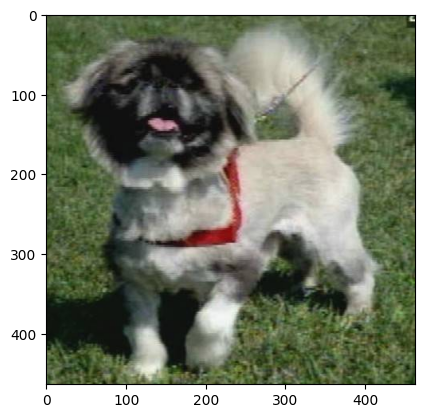

In [7]:
sample = random.choice(filenames)
image = load_img("input/train/"+sample)
plt.imshow(image)

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

In [9]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [10]:
earlystop = EarlyStopping(patience=10)

In [11]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_acc', 
    patience=2, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001
    )

In [12]:
callbacks = [earlystop, learning_rate_reduction]


In [13]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [14]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [15]:
train_df['category'].value_counts()

category
dog    10015
cat     9985
Name: count, dtype: int64

In [16]:
validate_df['category'].value_counts()

category
cat    2515
dog    2485
Name: count, dtype: int64

In [17]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [18]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "input/train/", 
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [19]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "input/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [20]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "input/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


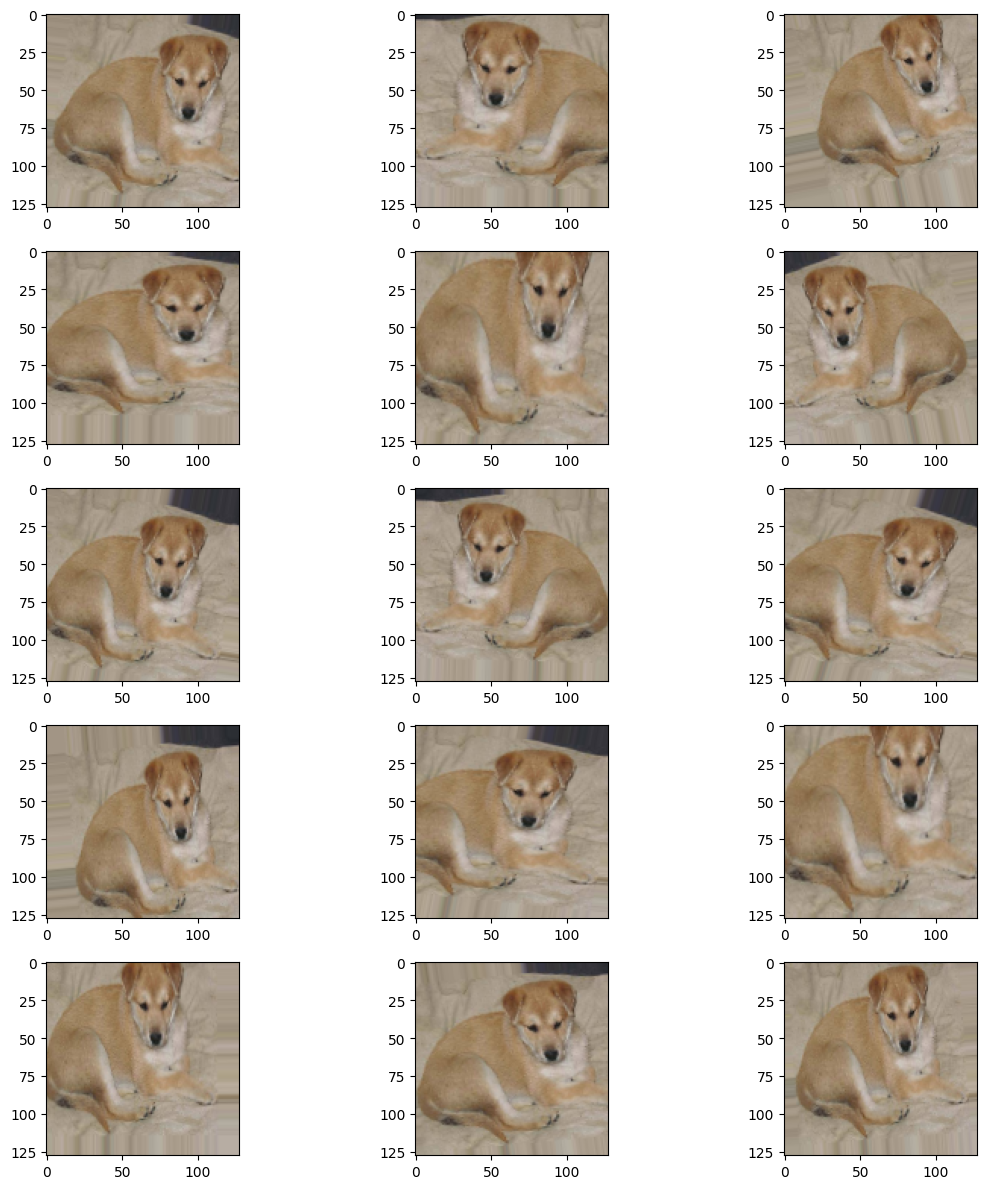

In [21]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [60]:
# epochs=3 if FAST_RUN else 50
# history = model.fit_generator(
#     train_generator, 
#     epochs=epochs,
#     validation_data=validation_generator,
#     validation_steps=total_validate//batch_size,
#     steps_per_epoch=total_train//batch_size,
#     callbacks=callbacks
# )

epochs=1 if FAST_RUN else 1
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

C:\Users\whisn\AppData\Local\Temp\ipykernel_23296\2812734169.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


1333/1333 [==============================] - 863s 647ms/step - loss: 0.6338 - accuracy: 0.6721 - val_loss: 0.9957 - val_accuracy: 0.5884 - lr: 0.0010


In [61]:
model.save_weights("model.h5")

In [68]:
# history.history

{'loss': [0.6337794065475464],
 'accuracy': [0.6721040606498718],
 'val_loss': [0.9956883788108826],
 'val_accuracy': [0.5883883833885193],
 'lr': [0.001]}

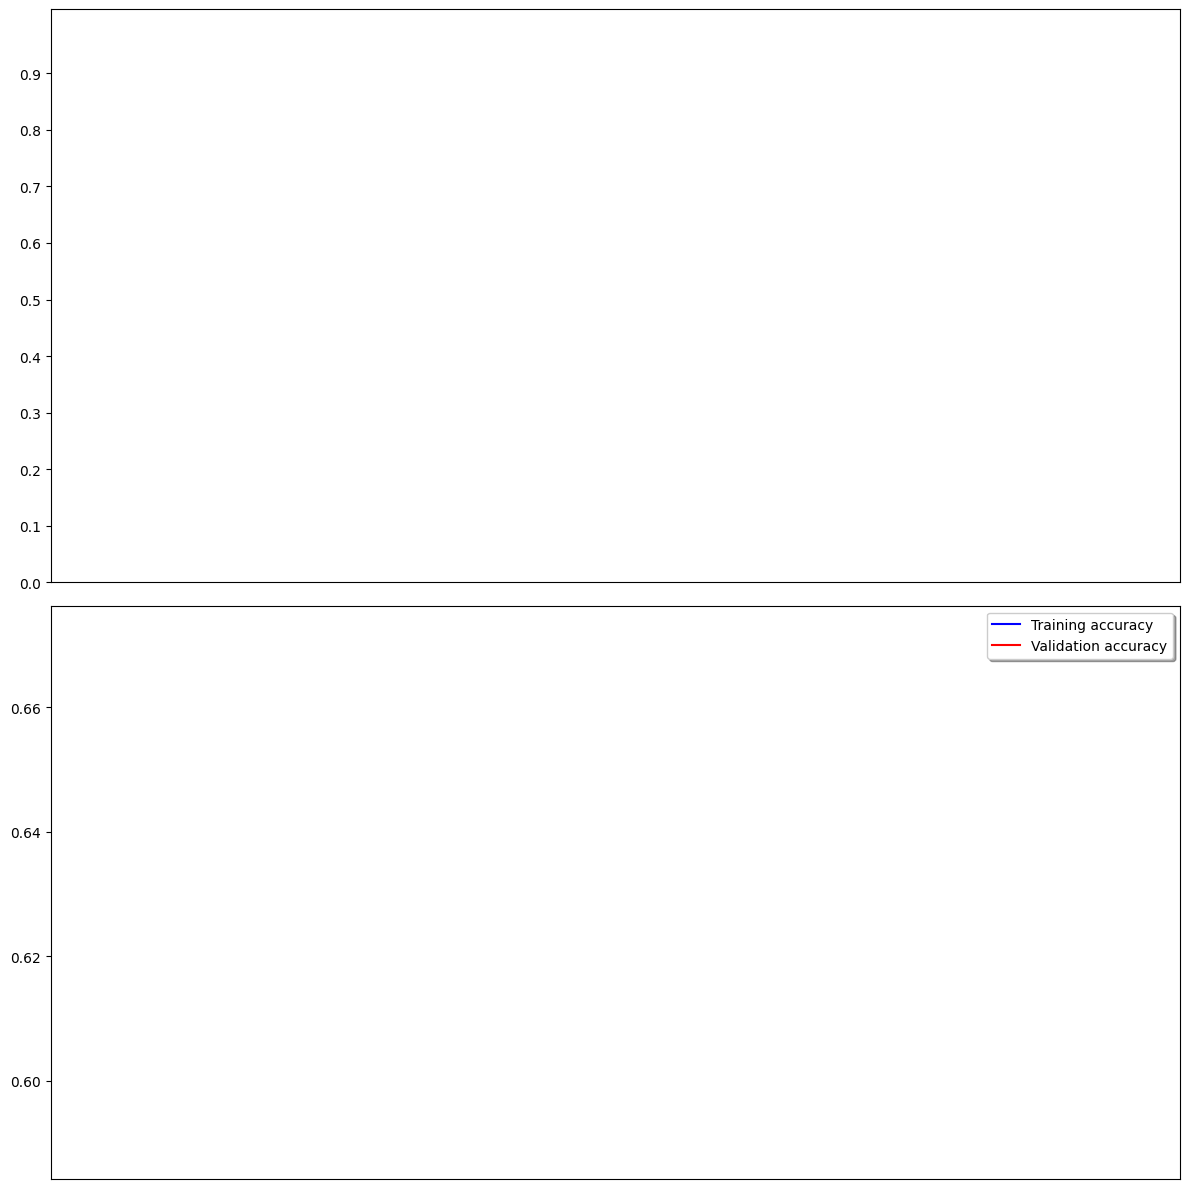

In [66]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [70]:
test_filenames = os.listdir("input/test1/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]
nb_samples

12500

In [71]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "input/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [72]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

C:\Users\whisn\AppData\Local\Temp\ipykernel_23296\3090721588.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [73]:
predict[4300]

array([0.19856185, 0.80143815], dtype=float32)

In [42]:
np.argmax(predict)

4300

In [74]:
test_df['category'] = np.argmax(predict, axis=-1)

In [75]:
sample_test = test_df.head(18)
sample_test.head() 

filename  category
0      1.jpg         1
1     10.jpg         0
2    100.jpg         1
3   1000.jpg         1
4  10000.jpg         1

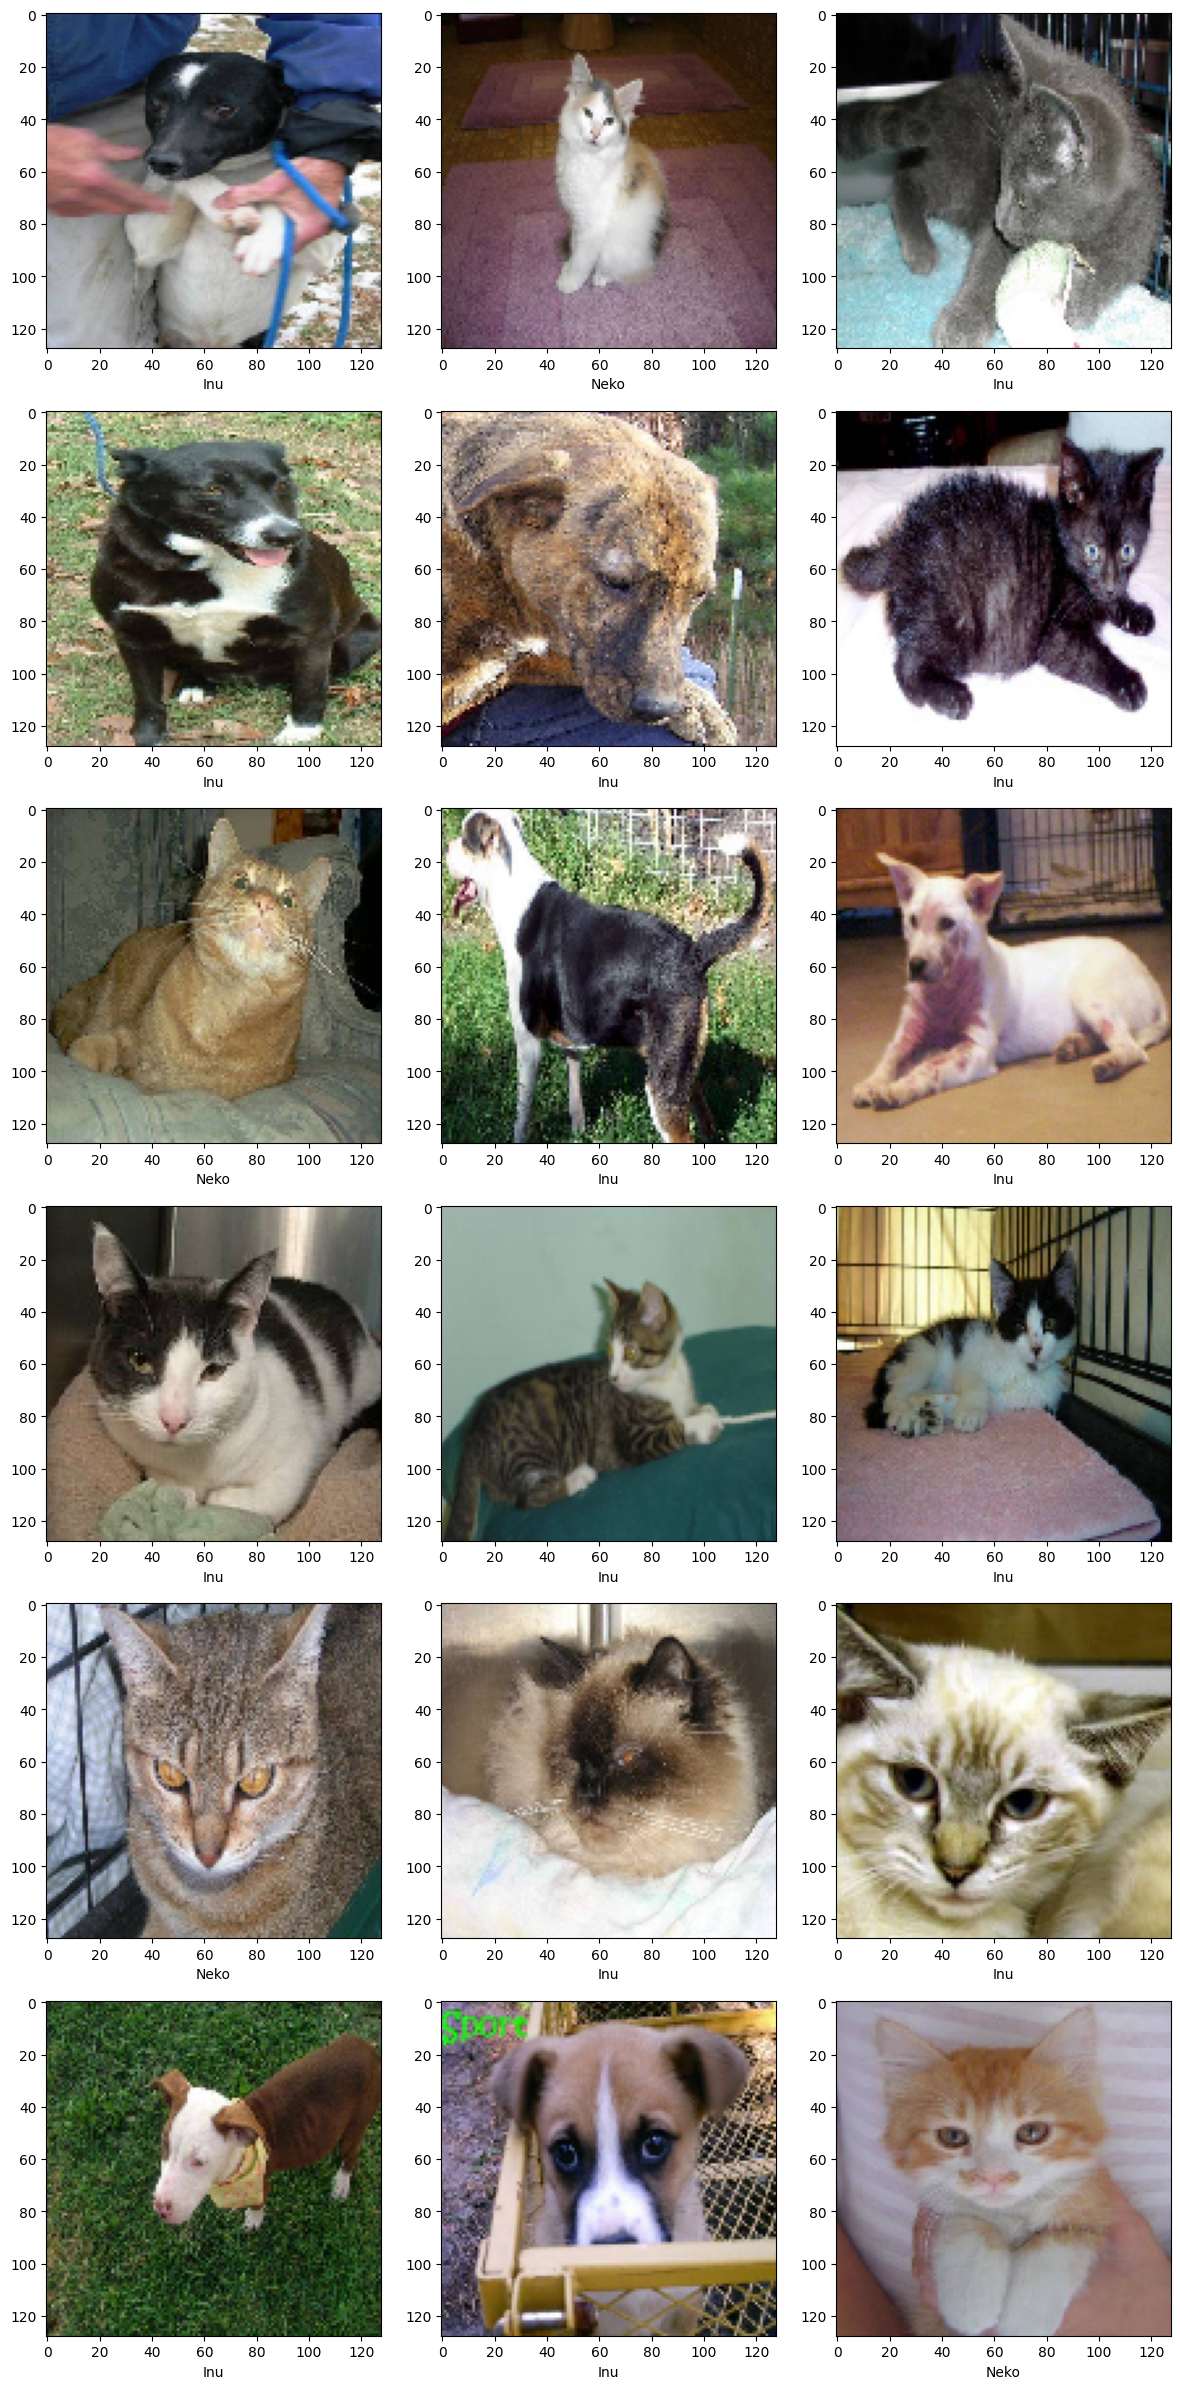

In [76]:
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("input/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    if category == 0:
        plt.xlabel('Neko')
    else:
        plt.xlabel('Inu')
          
    # plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [55]:
import numpy as np
from tensorflow.keras.preprocessing import image
import tensorflow as tf


In [ ]:
model = tf.keras.models.load_model('model.h5')

ValueError: No model config found in the file at <tensorflow.python.platform.gfile.GFile object at 0x0000022B55B3A1F0>.

In [ ]:
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("input/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    if category == 0:
        plt.xlabel('Neko')
    else:
        plt.xlabel('Inu')
          
    # plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [54]:
img_path = 'input/test1/1.jpg'  # Ganti dengan path gambar yang ingin Anda prediksi.
img = image.load_img(img_path, target_size=(100, 100))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img/255.0  # Normalisasi gambar jika diperlukan.

prediction = model.predict(img)

InvalidArgumentError: Graph execution error:

Detected at node 'sequential/dense/Relu' defined at (most recent call last):
    File "c:\Users\whisn\.conda\envs\viskom\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\whisn\.conda\envs\viskom\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\whisn\.conda\envs\viskom\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\whisn\.conda\envs\viskom\lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance
      app.start()
    File "c:\Users\whisn\.conda\envs\viskom\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "c:\Users\whisn\.conda\envs\viskom\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\whisn\.conda\envs\viskom\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\whisn\.conda\envs\viskom\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\whisn\.conda\envs\viskom\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\whisn\.conda\envs\viskom\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "c:\Users\whisn\.conda\envs\viskom\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "c:\Users\whisn\.conda\envs\viskom\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "c:\Users\whisn\.conda\envs\viskom\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "c:\Users\whisn\.conda\envs\viskom\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "c:\Users\whisn\.conda\envs\viskom\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\whisn\.conda\envs\viskom\lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "c:\Users\whisn\.conda\envs\viskom\lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "c:\Users\whisn\.conda\envs\viskom\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\whisn\.conda\envs\viskom\lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\whisn\.conda\envs\viskom\lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\whisn\.conda\envs\viskom\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\whisn\AppData\Local\Temp\ipykernel_23296\3090721588.py", line 1, in <module>
      predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
    File "C:\Users\whisn\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 2711, in predict_generator
      return self.predict(
    File "C:\Users\whisn\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\whisn\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 2382, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "C:\Users\whisn\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 2169, in predict_function
      return step_function(self, iterator)
    File "C:\Users\whisn\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 2155, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\whisn\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 2143, in run_step
      outputs = model.predict_step(data)
    File "C:\Users\whisn\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 2111, in predict_step
      return self(x, training=False)
    File "C:\Users\whisn\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\whisn\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\whisn\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\whisn\AppData\Roaming\Python\Python39\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\whisn\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\whisn\AppData\Roaming\Python\Python39\site-packages\keras\engine\sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\whisn\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\whisn\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\whisn\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\whisn\AppData\Roaming\Python\Python39\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\whisn\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\whisn\AppData\Roaming\Python\Python39\site-packages\keras\layers\core\dense.py", line 255, in call
      outputs = self.activation(outputs)
    File "C:\Users\whisn\AppData\Roaming\Python\Python39\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "C:\Users\whisn\AppData\Roaming\Python\Python39\site-packages\keras\backend.py", line 5396, in relu
      x = tf.nn.relu(x)
Node: 'sequential/dense/Relu'
Matrix size-incompatible: In[0]: [1,12800], In[1]: [25088,512]
	 [[{{node sequential/dense/Relu}}]] [Op:__inference_predict_function_2515]